# Alignment Algorithms

In [1]:
import io
import requests

import Bio.Align
import Bio.Entrez
import Bio.SeqIO
import Bio.Seq
import matplotlib.pyplot as plt

from src.alignment.global_ import nwalign
from src.alignment.local import swalign

Bio.Entrez.email = "your.email@example.com"

## Dot Plots

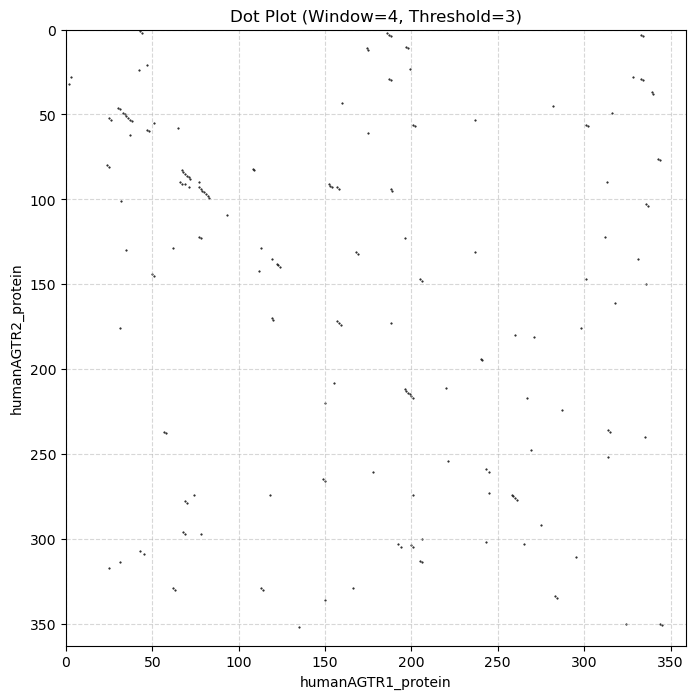

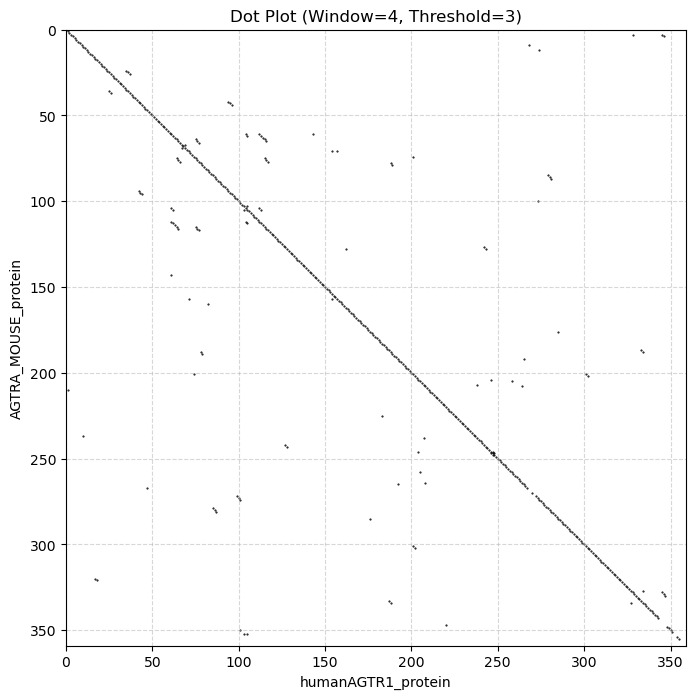

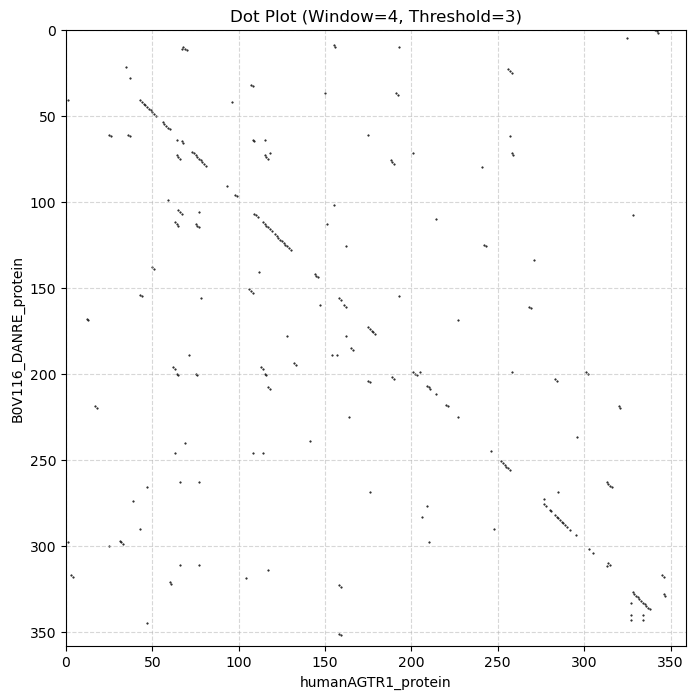

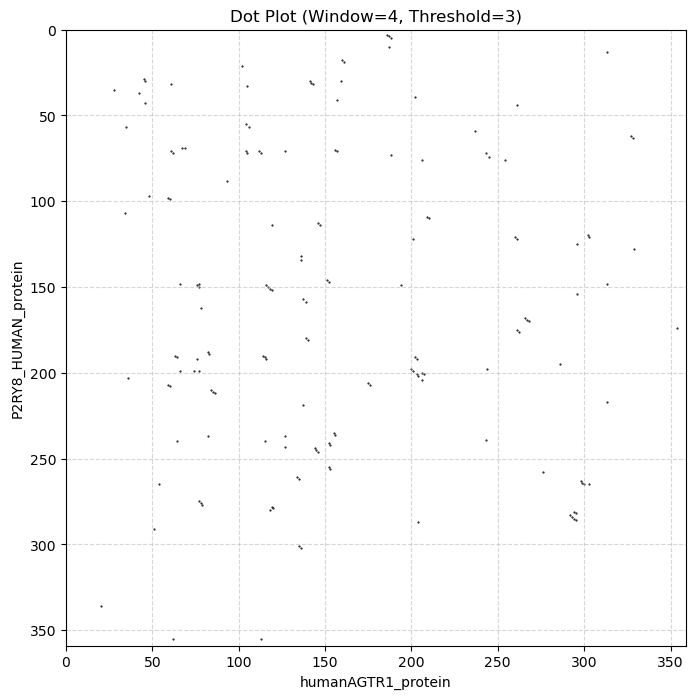

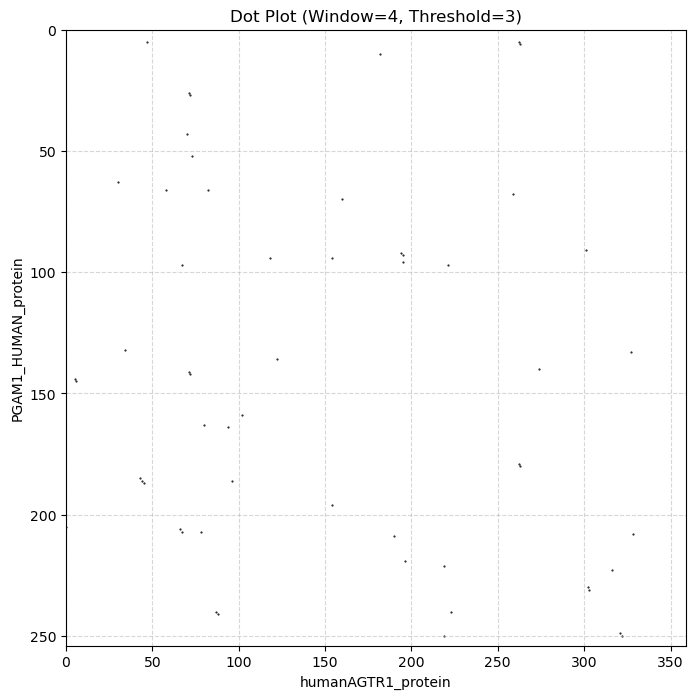

In [2]:
def getgenpept(accession: str, db: str = "protein") -> Bio.SeqIO.SeqRecord:
    """Equivalent to Matlab's getgenpept function."""
    with Bio.Entrez.efetch(db=db, id=accession, rettype="fasta", retmode="text") as handle:
        return Bio.SeqIO.read(handle, "fasta")


def get_from_uniprot(uniprot_id: str) -> Bio.SeqIO.SeqRecord:
    """Fetches a protein sequence string from UniProt."""
    (res := requests.get(f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta")).raise_for_status()
    with io.StringIO(res.text) as handle:
        return Bio.SeqIO.read(handle, "fasta")


def seqdotplot(seq1: Bio.Seq.Seq, seq1_label: str, seq2: Bio.Seq.Seq, seq2_label: str, *, window: int, threshold: int) -> None:
    """Creates a dot plot comparing two sequences. Equivalent to Matlab's dotplot function.

    x-axis is seq2, y-axis is seq1."""
    len1, len2 = len(seq1), len(seq2)
    match_coords_x, match_coords_y = [], []

    for i in range(len1 - window + 1):
        for j in range(len2 - window + 1):
            sub1, sub2 = seq1[i : i + window], seq2[j : j + window]
            matches = sum(c1 == c2 for c1, c2 in zip(sub1, sub2))
            if matches >= threshold:
                match_coords_x.append(j)
                match_coords_y.append(i)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(match_coords_x, match_coords_y, s=1, c="black", marker=".")  # s=size, c=color
    ax.set_xlim(0, len2)
    ax.set_ylim(0, len1)
    ax.invert_yaxis()  # Match typical dot plot orientation
    ax.set_xlabel(seq2_label)
    ax.set_ylabel(seq1_label)
    ax.set_title(f"Dot Plot (Window={window}, Threshold={threshold})")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


humanAGTR1_protein = getgenpept("P30556")
humanAGTR2_protein = getgenpept("P50052")
AGTRA_MOUSE_protein = getgenpept("P29754")
"""The orthologue (similar gene in a different species) of AGTR1 in mice."""
B0V116_DANRE_protein = get_from_uniprot("B0V116")
"""The orthologue of AGTR1 in zebrafish."""
P2RY8_HUMAN_protein = getgenpept("Q86VZ1")
"""Another protein from the G protein-coupled receptor family, but otherwise unrelated to AGTR1."""
PGAM1_HUMAN_protein = getgenpept("P18669")
"""An enzyme that plays an important role in glycolysis and gluconeogenesis, and is unrelated to AGTR1."""

seqdotplot(humanAGTR2_protein.seq, "humanAGTR2_protein", humanAGTR1_protein.seq, "humanAGTR1_protein", window=4, threshold=3)
seqdotplot(AGTRA_MOUSE_protein.seq, "AGTRA_MOUSE_protein", humanAGTR1_protein.seq, "humanAGTR1_protein", window=4, threshold=3)
seqdotplot(B0V116_DANRE_protein.seq, "B0V116_DANRE_protein", humanAGTR1_protein.seq, "humanAGTR1_protein", window=4, threshold=3)
seqdotplot(P2RY8_HUMAN_protein.seq, "P2RY8_HUMAN_protein", humanAGTR1_protein.seq, "humanAGTR1_protein", window=4, threshold=3)
seqdotplot(PGAM1_HUMAN_protein.seq, "PGAM1_HUMAN_protein", humanAGTR1_protein.seq, "humanAGTR1_protein", window=4, threshold=3)

**Which pairs of sequences do you expect to have strong alignment scores based on the plots**?

Related genes should show the most similarity.

`humanAGTR1_protein` and `AGTRA_MOUSE_protein` show a lot of similarity. The zebrafish is already more distant from humans than mice, so it makes sense that the `B0V116_DANRE_protein` shows less similarity to `humanAGTR1_protein`.

`humanAGTR2_protein` only shows a faint similarity to `humanAGTR1_protein`.

The two unrelated proteins show very little similarity to any other proteins.

## Global Alignment: The Needleman-Wunsch Algorithm

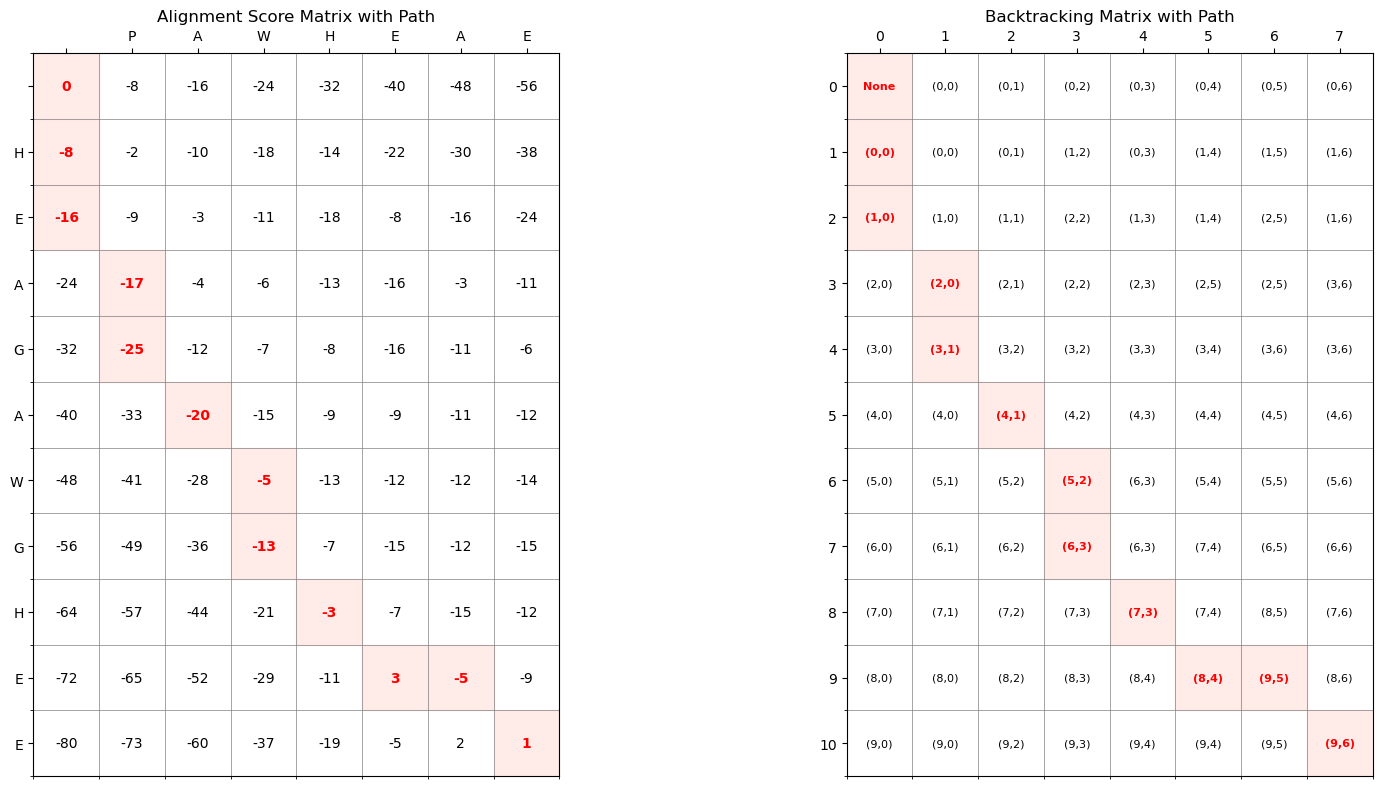

1 
HEAGAWGHE-E
    || || |
--P-AW-HEAE


In [3]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", gap_penalty=-8, substitution_matrix="BLOSUM50", plot=True)
print(global_score, global_alignment)

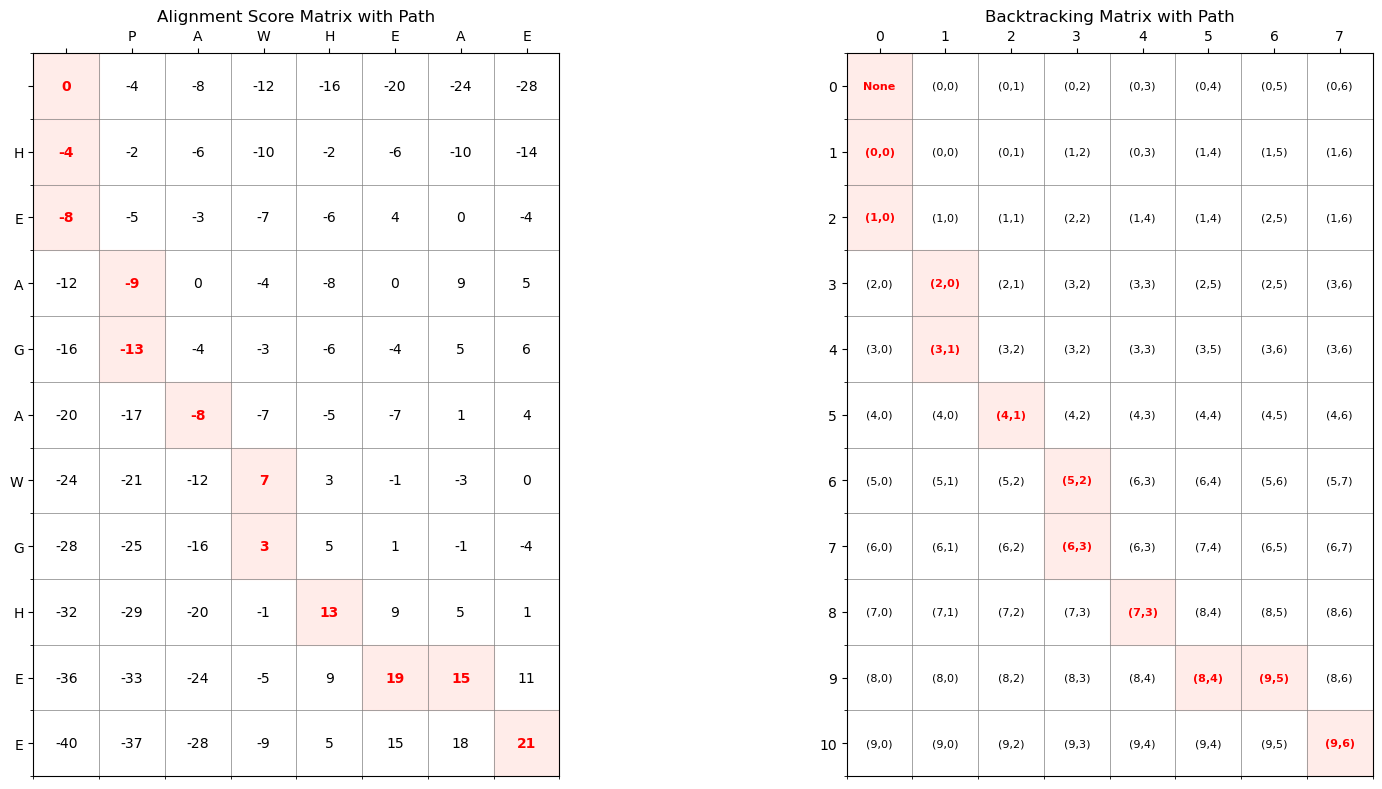

21 
HEAGAWGHE-E
    || || |
--P-AW-HEAE


In [4]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", gap_penalty=-4, substitution_matrix="BLOSUM50", plot=True)
print(global_score, global_alignment)

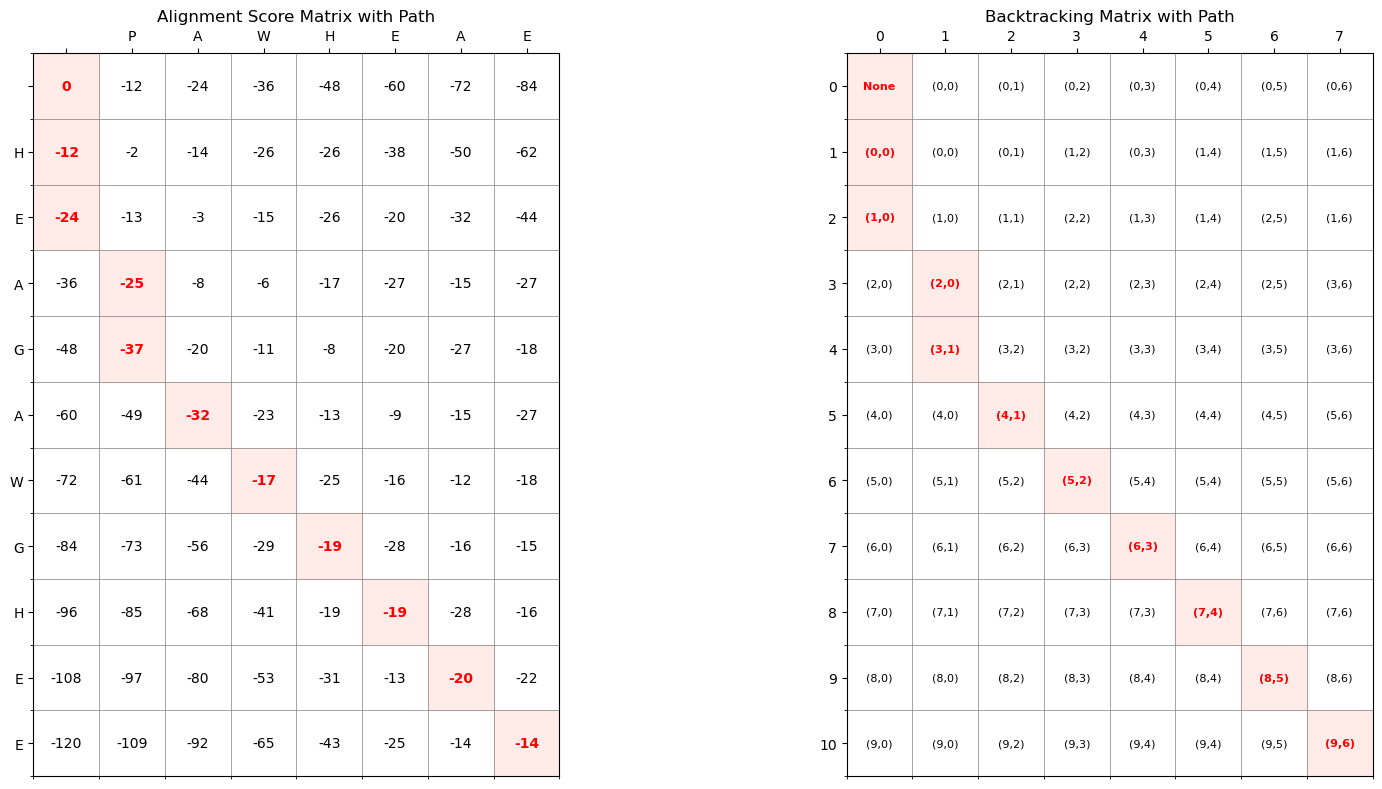

-14 
HEAGAWGHEE
    ||   |
--P-AWHEAE


In [5]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", gap_penalty=-12, substitution_matrix="BLOSUM50", plot=True)
print(global_score, global_alignment)

**Do different values for the gap penalty give different results**?

When you increase the gap penalty, each gap is more costly and the algorithm becomes more reluctant to introduce gaps.

- Option 1: Insert a gap (penalty `-12`) to gain two matches (benefit).
- Option 2: Skip the gap and accept mismatches if cost outweights benefit.

A gap penalty of `-12` (relative to a penalty of only `-4` or `-8`) causes gaps to be penalised more so that a gap in sequence 1 between the last two `E`s is forgone - which would have made two further exact matches (`H` and `E`) possible.

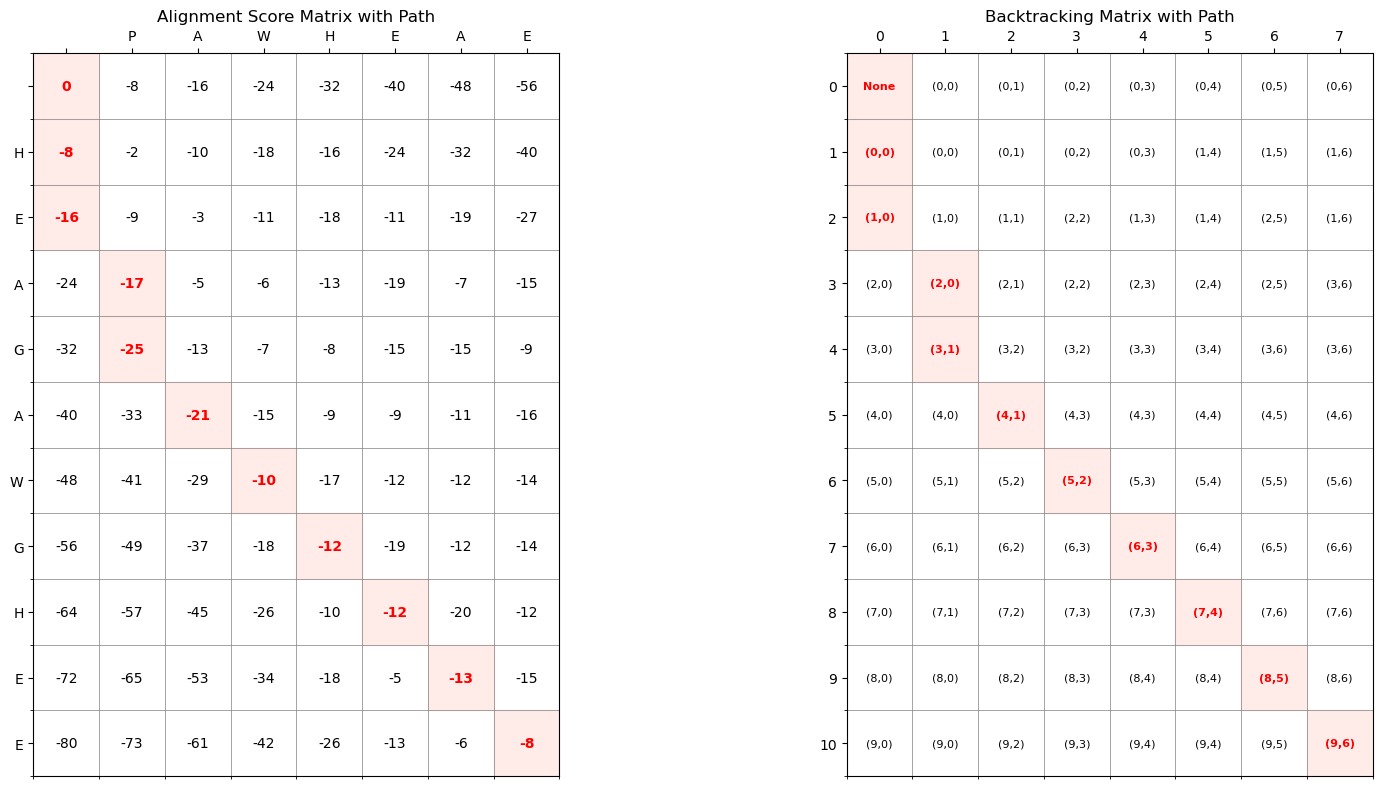

-8 
HEAGAWGHEE
    ||   |
--P-AWHEAE


In [6]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", substitution_matrix="BLOSUM62", plot=True)
print(global_score, global_alignment)

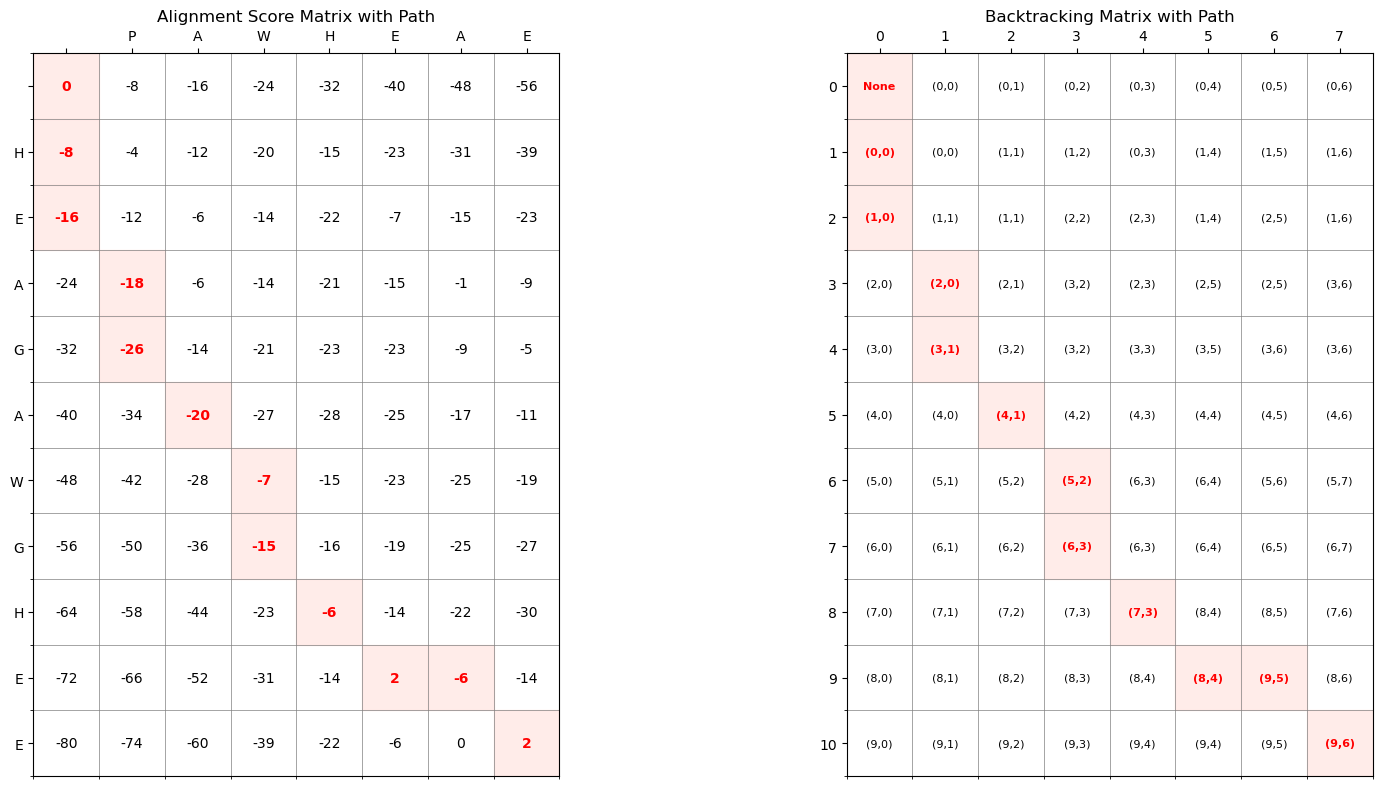

2 
HEAGAWGHE-E
    || || |
--P-AW-HEAE


In [7]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", substitution_matrix="PAM30", plot=True)
print(global_score, global_alignment)

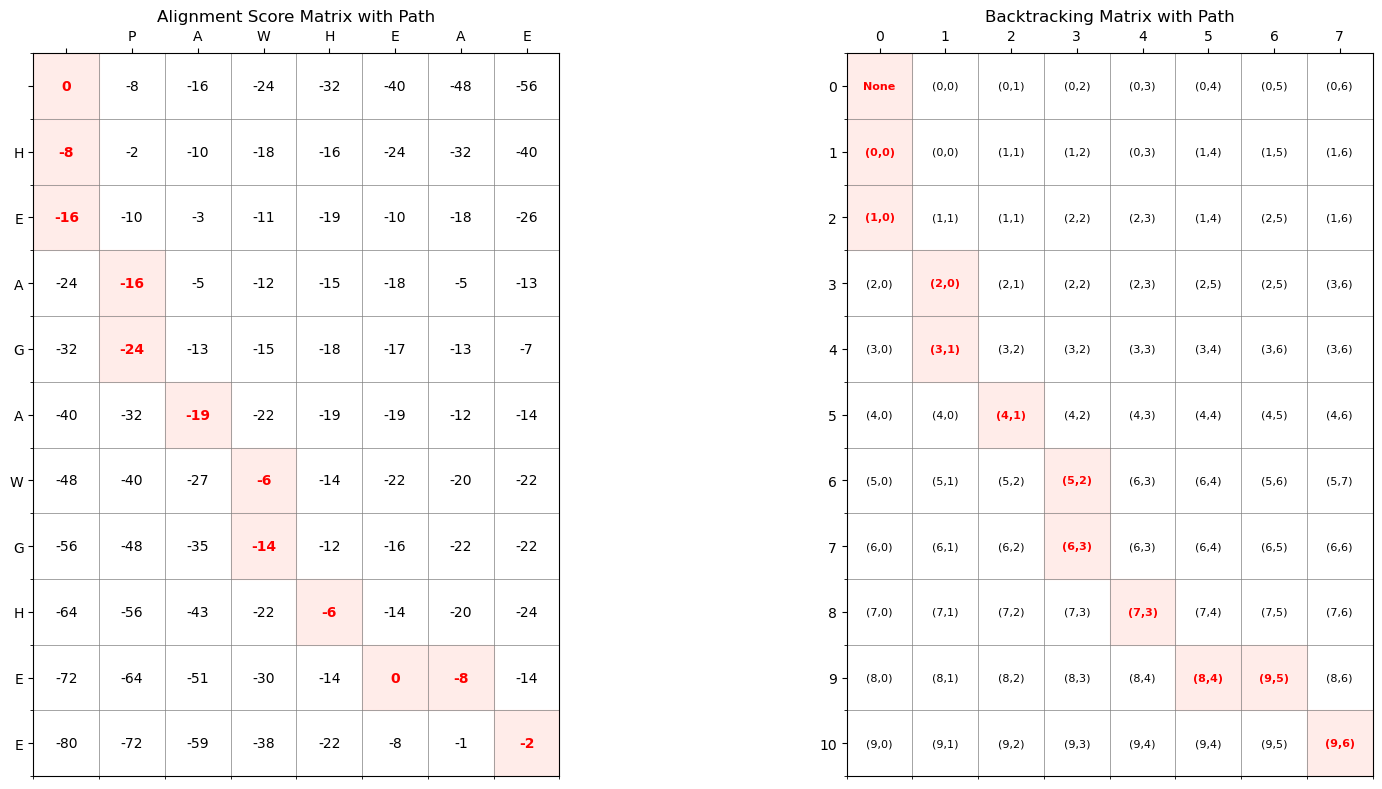

-2 
HEAGAWGHE-E
    || || |
--P-AW-HEAE


In [8]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", substitution_matrix="PAM70", plot=True)
print(global_score, global_alignment)

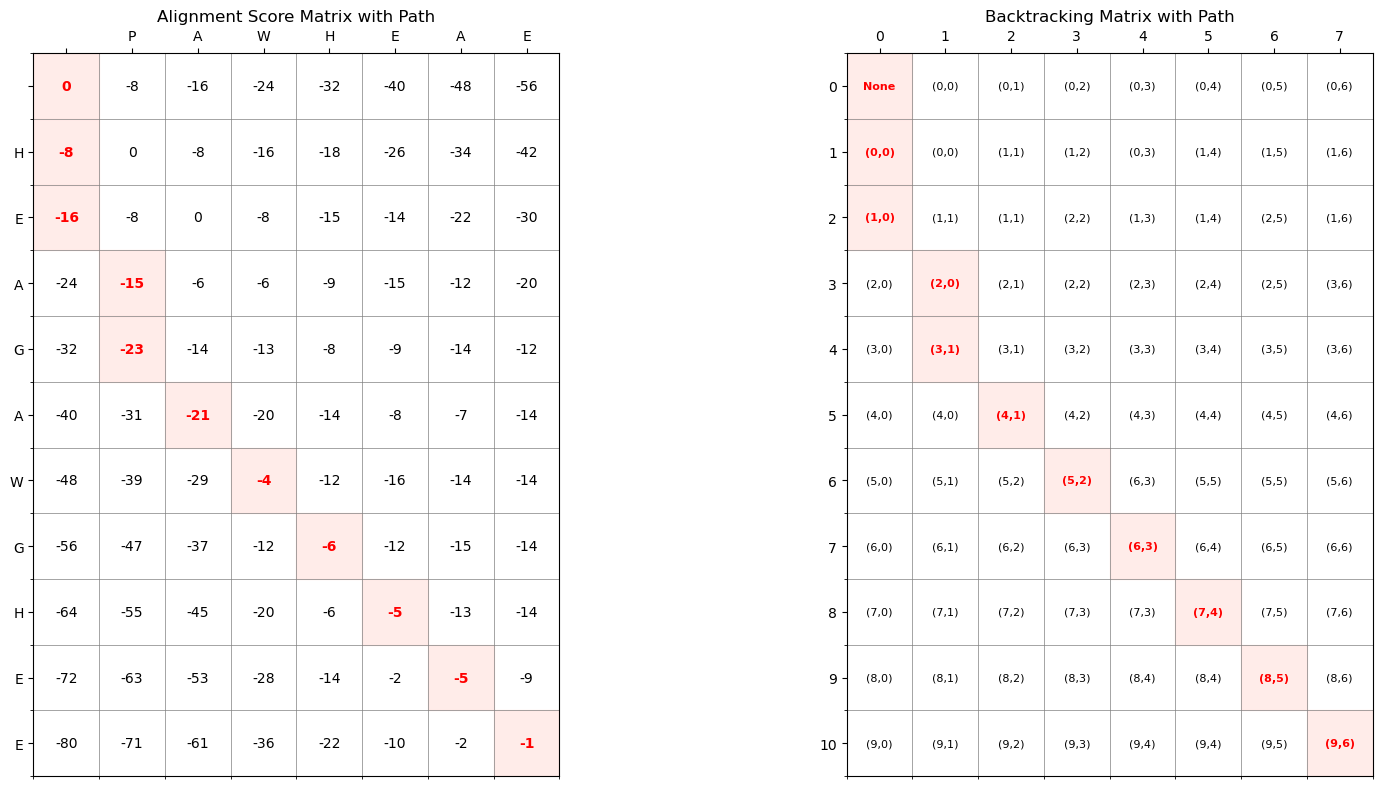

-1 
HEAGAWGHEE
  : || : |
--P-AWHEAE


In [9]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", substitution_matrix="PAM250", plot=True)
print(global_score, global_alignment)

**What do the symbols `|` and `:` indicate**?

From Mathworks:

- The symbol `|` indicates amino acids or nucleotides that match exactly.
- The symbol `:` indicates amino acids or nucleotides that are related as defined by the scoring matrix (nonmatches with a zero or positive scoring matrix value).

In [10]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, humanAGTR2_protein.seq)
print("humanAGTR1_protein - humanAGTR2_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq)
print("humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, B0V116_DANRE_protein.seq)
print("humanAGTR1_protein - B0V116_DANRE_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq)
print("humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, PGAM1_HUMAN_protein.seq)
print("humanAGTR1_protein - PGAM1_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

humanAGTR1_protein - humanAGTR2_protein global alignment score: 638 
MILNS---ST-ED---GIK----RI----QD--DCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMK-LKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFFIENTNITVCAFHYESQN-STLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCFEVE
|  ||   :| ::   |:      |    :   :| :     ::   || || ||||:| : | :||: ::   |  | |:|::::|||:||| :| |||||| | :  | | ||  :||:  : :::|::||:|::||:|:||| ::::|  |: ||    |     ::| :| |:|||    |:|  ||   :  |   :  :  :    |: | ||||||: |:: | | |  | | | |     ||:   | ::|:  |:|| |   |:| :::|||| |  :|:|  | :  ::| |:|  | : : |:|:||::| |:| :|:: :  ::: : |   :   |  |  ::| |     ||| ::    | | 
MKGNSTLATTSKNITSGLHFGLVNISGNNESTLNCSQKPSDKHL-DAIPILYYIIFVIGFLVN-IVVVTLFCCQKGPKKVSSIYIFNLAVADLLLLATLPLWATYYSYRYDWLFGPVMCKVFGSFLTLNMFASIFFITCMSVDRYQSVIYPFLSQ-RRNPWQASYIVPLVWCM

**Do the global alignment scores agree with the dot plots**?

Yes!

In [11]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq, substitution_matrix="BLOSUM50")
print("humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq, substitution_matrix="BLOSUM90")
print("humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq, substitution_matrix="PAM30")
print("humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq, substitution_matrix="PAM70")
print("humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score:", global_score, global_alignment)
print()

humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score: 2274 
MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFFIENTNITVCAFHYESQNSTLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCFEVE
| |||||||||||||||||:||||:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||:|||||||||||||||||||||||||||||||||||||||||||||||||||||||:||||||||:|||||:||||||||||||||||:||||||||||||||||||||||||||||||||||||||||||||||||||||:|||||||||||||:|||||||||||||||:| ||:|||||||||||||||||||||||||||||||||||:|||||||||||||||||:|||||||||||||||:||: |||| | |||
MALNSSTEDGIKRIQDDCPRAGRHSYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNHLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLMAGLASLPAVIHRNVYFIENTNITVCAFHYESRNSTLPIGLGLTKNILGFLFPFL

In [12]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq, substitution_matrix="BLOSUM50")
print("humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq, substitution_matrix="BLOSUM45")
print("humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq, substitution_matrix="PAM70")
print("humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

global_score, global_alignment = nwalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq, substitution_matrix="PAM250")
print("humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score: 344 
MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKS-RLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFF-IENTNITVCAFHYESQNSTLP-IGL-G--L-TKNILGFLFPFLIILTSYT-LIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFK-RYFLQL-LKYIP--P-KAKSHSNLSTKMSTL-SYRPS--DNVSSSTKKPAPCFE-VE
| : :||  |     :   :  |:  | | :| :||::  | | || : : |:   |  :: : :|::||:: || :   ||:   |    : | ||  || : : :   |:|:|:: :||:|::|:| :::|: | | ||    |   |   |||  | :|  :   :: : :    |  | |      : || : :    | |  || || ||:| :  ||  | | | :  | :  : |   :  :   ::| |   : |:  |  |  | :: : |             :|:|:: :||||:|: | |  ::|: |    |  : :|      :  | :| : ::: |   :  : :  :|:      | | 
MQVPNST--G-P--DNATLQMLRNPAIAVALPVVYSLVAAVSIPGNLFSLWVLCRRMGPRSPSVIFMINLSVTDLMLASVLPFQIYYHCNRHHWVFGVLLCNVVTVAFYANMYSSILTMTCISVERFLGVLYPLSSKRWRRRR-YAVAACAGTWLLL-LTALSPLARTDLTYPVHA

**Do different substitution matrices give different results**?

- `BLOSUM` matrices: The number (e.g., `BLOSUM62`) represents the sequence identity percentage threshold used to cluster sequences when creating the matrix. `BLOSUM62` was built using sequences with $\leq 62\%$ identity.
- `PAM` matrices: The number (e.g., `PAM250`) represents evolutionary distance - higher numbers indicate greater evolutionary distance.

For BLOSUM matrices:

- Higher numbers (`BLOSUM80`, `BLOSUM90`) come from more closely related sequences.
- They have higher match scores and harsher mismatch penalties
- This makes substitutions relatively more costly compared to gaps
- So the appearance of stronger gap penalties is actually due to the relative costs

For PAM matrices:

- Lower numbers (`PAM30`) represent closely related sequences
- Higher numbers (`PAM250`) represent distant evolutionary relationships
- In distant evolutionary relationships, insertions/deletions become more common
- So `PAM250` should actually be more permissive of gaps than `PAM30`

## Local Alignment: The Smith-Waterman Algorithm

Alignment between subsequences.

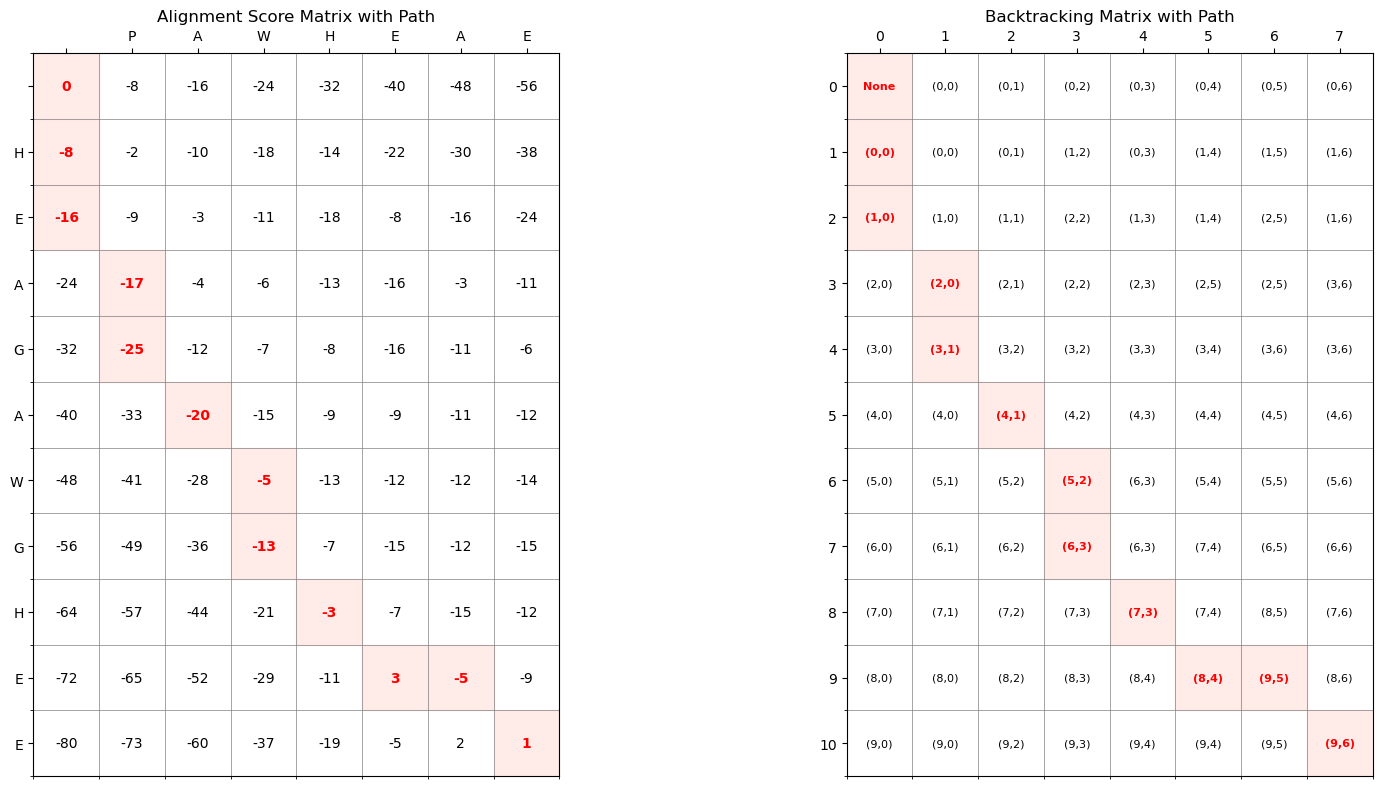

1 
HEAGAWGHE-E
    || || |
--P-AW-HEAE


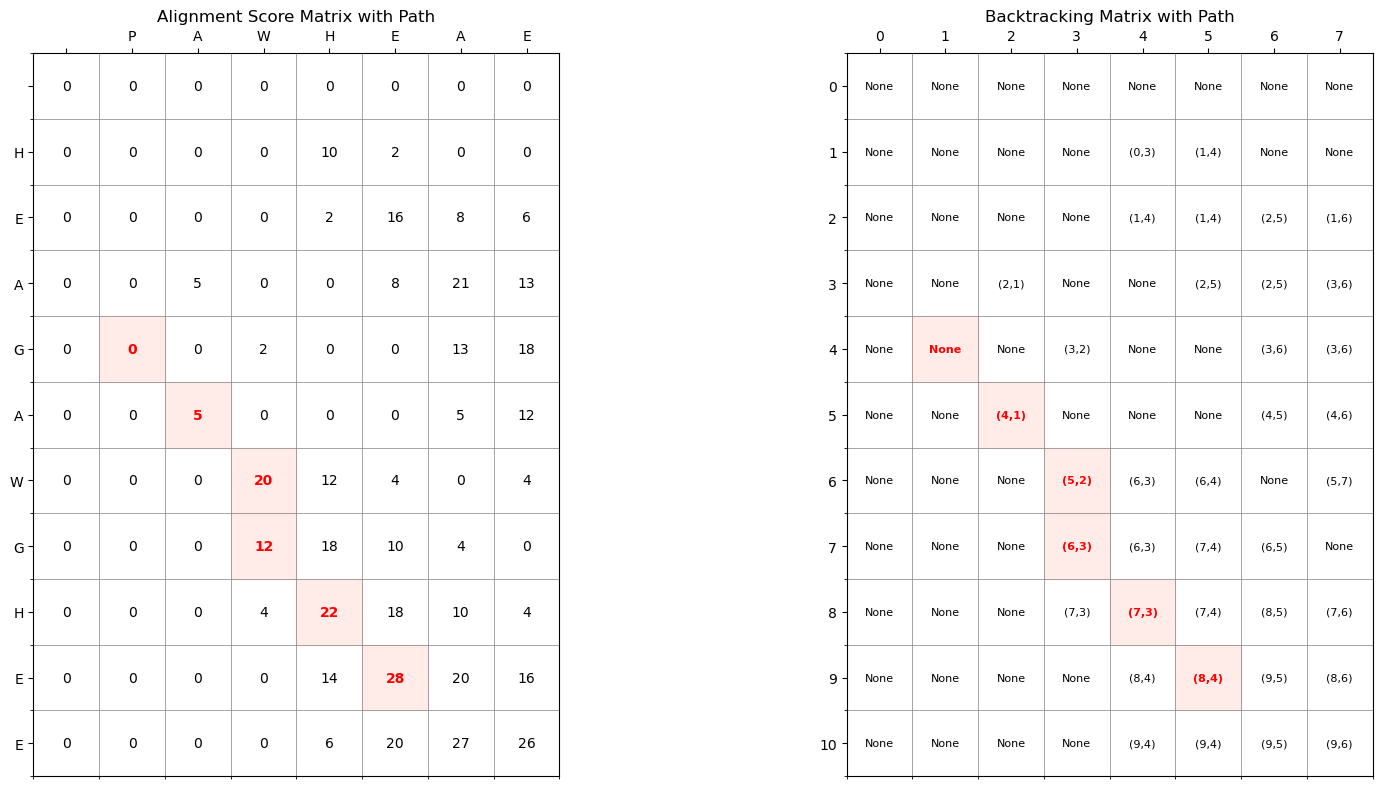

28 
AWGHE
|| ||
AW-HE


In [13]:
global_score, global_alignment = nwalign("HEAGAWGHEE", "PAWHEAE", gap_penalty=-8, substitution_matrix="BLOSUM50", plot=True)
print(global_score, global_alignment)

global_score, global_alignment = swalign("HEAGAWGHEE", "PAWHEAE", gap_penalty=-8, substitution_matrix="BLOSUM50", plot=True)
print(global_score, global_alignment)

In [14]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, humanAGTR2_protein.seq)
print("humanAGTR1_protein - humanAGTR2_protein global alignment score:", global_score, global_alignment)
print()

local_score, local_alignment = swalign(humanAGTR1_protein.seq, humanAGTR2_protein.seq)
print("humanAGTR1_protein - humanAGTR2_protein local alignment score:", local_score, local_alignment)
print()

humanAGTR1_protein - humanAGTR2_protein global alignment score: 638 
MILNS---ST-ED---GIK----RI----QD--DCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMK-LKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFFIENTNITVCAFHYESQN-STLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCFEVE
|  ||   :| ::   |:      |    :   :| :     ::   || || ||||:| : | :||: ::   |  | |:|::::|||:||| :| |||||| | :  | | ||  :||:  : :::|::||:|::||:|:||| ::::|  |: ||    |     ::| :| |:|||    |:|  ||   :  |   :  :  :    |: | ||||||: |:: | | |  | | | |     ||:   | ::|:  |:|| |   |:| :::|||| |  :|:|  | :  ::| |:|  | : : |:|:||::| |:| :|:: :  ::: : |   :   |  |  ::| |     ||| ::    | | 
MKGNSTLATTSKNITSGLHFGLVNISGNNESTLNCSQKPSDKHL-DAIPILYYIIFVIGFLVN-IVVVTLFCCQKGPKKVSSIYIFNLAVADLLLLATLPLWATYYSYRYDWLFGPVMCKVFGSFLTLNMFASIFFITCMSVDRYQSVIYPFLSQ-RRNPWQASYIVPLVWCM

In [15]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq)
print("humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score:", global_score, global_alignment)
print()

local_score, local_alignment = swalign(humanAGTR1_protein.seq, AGTRA_MOUSE_protein.seq)
print("humanAGTR1_protein - AGTRA_MOUSE_protein local alignment score:", local_score, local_alignment)
print()

humanAGTR1_protein - AGTRA_MOUSE_protein global alignment score: 2274 
MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFFIENTNITVCAFHYESQNSTLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCFEVE
| |||||||||||||||||:||||:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||:|||||||||||||||||||||||||||||||||||||||||||||||||||||||:||||||||:|||||:||||||||||||||||:||||||||||||||||||||||||||||||||||||||||||||||||||||:|||||||||||||:|||||||||||||||:| ||:|||||||||||||||||||||||||||||||||||:|||||||||||||||||:|||||||||||||||:||: |||| | |||
MALNSSTEDGIKRIQDDCPRAGRHSYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNHLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLMAGLASLPAVIHRNVYFIENTNITVCAFHYESRNSTLPIGLGLTKNILGFLFPFL

In [16]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, B0V116_DANRE_protein.seq)
print("humanAGTR1_protein - B0V116_DANRE_protein global alignment score:", global_score, global_alignment)
print()

local_score, local_alignment = swalign(humanAGTR1_protein.seq, B0V116_DANRE_protein.seq)
print("humanAGTR1_protein - B0V116_DANRE_protein local alignment score:", local_score, local_alignment)
print()

humanAGTR1_protein - B0V116_DANRE_protein global alignment score: 1171 
MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCK-IASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLA-GLASLPAIIHRNVFFIENTNITVCAFHYESQNSTLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRN-DDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCF-EVE
|  :: | |    :   |   | |::||  || :||  |::|: |||||| |||| :||||||::|::|||::|| ||||||:||: ||  | | ||: ||| ||  :: :||| |:|||| ||:|||||||||::||  ||:: |:|||:::|::: || |||  | |   ||:: |:|||| |::     :   | | |:::|||:|  :||| | || :|| || :||:|   | |::: :: |  | ||: | ||||| |:::|: | :|  | : ||:|| || |||||:||:|:||::| |:|| |:| :|:||:       ||  ||||||:|||| |:    |  |  | :    
M--DNVTSDSNTGLALACNMTGHHSFIFTFIPVVYSFNFIIGLIGNSLVVAVIYFCLKLKTVANIFVFNLAVSDLTFLLTLPIWAISTATGYHWLFGDLLCKTIAGMAL-LNLYTSIFLLTALSVDRYLAIVHPVQSRRCRTVIYARVTCVLVWVVSFGL-SLPTAIIRGTHFIQDNNVTVCAIHHKEDIRNVLAALSLM

In [17]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq)
print("humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

local_score, local_alignment = swalign(humanAGTR1_protein.seq, P2RY8_HUMAN_protein.seq)
print("humanAGTR1_protein - P2RY8_HUMAN_protein local alignment score:", local_score, local_alignment)
print()

humanAGTR1_protein - P2RY8_HUMAN_protein global alignment score: 344 
MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKS-RLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFF-IENTNITVCAFHYESQNSTLP-IGL-G--L-TKNILGFLFPFLIILTSYT-LIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFK-RYFLQL-LKYIP--P-KAKSHSNLSTKMSTL-SYRPS--DNVSSSTKKPAPCFE-VE
| : :||  |     :   :  |:  | | :| :||::  | | || : : |:   |  :: : :|::||:: || :   ||:   |    : | ||  || : : :   |:|:|:: :||:|::|:| :::|: | | ||    |   |   |||  | :|  :   :: : :    |  | |      : || : :    | |  || || ||:| :  ||  | | | :  | :  : |   :  :   ::| |   : |:  |  |  | :: : |             :|:|:: :||||:|: | |  ::|: |    |  : :|      :  | :| : ::: |   :  : :  :|:      | | 
MQVPNST--G-P--DNATLQMLRNPAIAVALPVVYSLVAAVSIPGNLFSLWVLCRRMGPRSPSVIFMINLSVTDLMLASVLPFQIYYHCNRHHWVFGVLLCNVVTVAFYANMYSSILTMTCISVERFLGVLYPLSSKRWRRRR-YAVAACAGTWLLL-LTALSPLARTDLTYPVHA

In [18]:
global_score, global_alignment = nwalign(humanAGTR1_protein.seq, PGAM1_HUMAN_protein.seq)
print("humanAGTR1_protein - PGAM1_HUMAN_protein global alignment score:", global_score, global_alignment)
print()

local_score, local_alignment = swalign(humanAGTR1_protein.seq, PGAM1_HUMAN_protein.seq)
print("humanAGTR1_protein - PGAM1_HUMAN_protein local alignment score:", local_score, local_alignment)
print()

humanAGTR1_protein - PGAM1_HUMAN_protein global alignment score: -520 
MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFFIENTNITVCAFHYESQNSTLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCFEVE
|   ::     | :        ||         | :  |  | :   |     :   | :   ::      : |:||  ::   |: | :   |     |     | :   ::  |     |: :|:   :  : ::        :   : ||  :     | :   : |:   :||:    : :     ||    | |: :   :||          |   :   :|:: | |   :  :| |       :   |      : | : ||::   :  : : |    | :  : | | |   | :      |  :| | : |  |    |  :  |:  :  : |::   | |   : :
M---AA----YKLV---L--I-RHGE-SAW--NLEN-RF-SGWYDADL-SPAGHEEAK-RGGQALRDAGYEF-DICF-TSVQKRAIRT-L---W---TVL----DA-ID-QMWLPVVRTWRLN-ERHYGGLTGL-NKAETAAKHGEAQ-VKIWRRSYDVPPPPMEPDHPFY---SNISKDRRYADLTEDQLPSCESL-KDTIARALPF-

**What proteins score well with local alignment**?

- For highly similar sequences (e.g. human/mouse orthologues): Both algorithms produce nearly identical alignments with high scores. This indicates complete similarity along the entire sequence length.
- For moderately similar sequences: Local alignment gives slightly higher scores. It focuses on the regions of similarity while ignoring divergent regions.
- For dissimilar sequences: Global alignment produces strongly negative scores. Local alignment still finds small regions of similarity, giving weak positive scores.

Needleman-Wunsch (Global):

- Forces end-to-end alignment of both sequences
- Penalises every gap and mismatch throughout the entire sequence
- Best for comparing closely related sequences expected to have similarity across their whole length
- May produce misleading alignments when sequences differ in length or have divergent regions
- Negative scores are meaningful - they indicate sequences less similar than random

Smith-Waterman (Local):

- Identifies only the best matching subsequences
- Ignores poorly matching regions at sequence ends
- Scores are always non-negative (algorithm floors at zero)
- Better for detecting conserved domains or motifs in otherwise different sequences
- More appropriate for comparing distantly related sequences

**Practical applications**:

- Use global alignment when comparing orthologues or sequences expected to be similar throughout
- Use local alignment when searching for conserved domains or when comparing more distantly related sequences
- Local alignment is generally more useful for database searches (like BLAST)
- Global alignment provides a better measure of overall sequence similarity

The differences reflect the fundamental biological reality that distant evolutionary relationships often preserve functional domains while allowing other regions to diverge.